In [1]:
import numpy as np
from copy import deepcopy
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers,regularizers,metrics,optimizers
import random
import pandas as pd
from scipy.linalg import sqrtm
import pickle
from typing import Any, Callable, Dict, List, Optional, Union
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import math
import scipy.stats as st
from scipy.special import comb
from collections import defaultdict

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config=tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth=True
sess=tf.compat.v1.Session(config=config) 

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255
y_train_onehot=tf.keras.utils.to_categorical(y_train,num_classes=10)
y_test_onehot=tf.keras.utils.to_categorical(y_test,num_classes=10)
y_train=y_train.reshape(50000)

In [ ]:
"""This code is the second part of the code used to generate the redundancy evaluation algorithm's distillation data 
on VGGNet-16. Based on the distillation data that has already learned some data features from the first part, by using 
the output of the last hidden layer of ResNet-18 from both the original data and the distillation data, the differences 
in their means and variances are calculated. This allows for fine-tuning of the distillation data, enabling it to 
achieve a high accuracy rate on the ResNet-18 network. This ensures that the distillation data meets the requirement that 
the data used by the evaluation algorithm must be fully learned by the network."""

In [4]:
initial_lr = 1e-2
epochs = 400
warmup_epochs = 10

In [5]:
batch=2000

In [6]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, total_steps, warmup_steps, warmup_lr=0.0):
        super().__init__()
        self.base_lr = base_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.warmup_lr = warmup_lr
    def __call__(self, step):
        if step is None:
            step = tf.constant(0)
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        total_steps = tf.cast(self.total_steps, tf.float32)
        warmup_percent_done = step / warmup_steps
        learning_rate = tf.where(
            step < warmup_steps,
            self.warmup_lr + (self.base_lr - self.warmup_lr) * warmup_percent_done,
            self.base_lr * 0.5 * (1.0 + tf.cos(math.pi * (step - warmup_steps) / (total_steps - warmup_steps)))
        )
        return learning_rate
    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "total_steps": self.total_steps,
            "warmup_steps": self.warmup_steps,
            "warmup_lr": self.warmup_lr,
        }

In [7]:
class CustomWeightDecaySGD(tf.keras.optimizers.SGD):
    def __init__(self, weight_decay, **kwargs):
        super().__init__(**kwargs)
        self.weight_decay = weight_decay

    def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
        new_grads_and_vars = []
        for (grad, var) in grads_and_vars:
            if ('kernel' in var.name) and ('bn' not in var.name.lower()):
                grad += self.weight_decay * var
            new_grads_and_vars.append((grad, var))
        return super().apply_gradients(new_grads_and_vars, name, experimental_aggregate_gradients)
    def get_config(self):
        return {
            "weight_decay": self.weight_decay,
            **super().get_config(),
        }

In [8]:
model_V=keras.models.load_model("VGG16_cifar10.h5",custom_objects={
        'CustomWeightDecaySGD': CustomWeightDecaySGD,
        'WarmUpCosine': WarmUpCosine
    })

In [9]:
model_V.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1728      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36864     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0

In [10]:
hidden_layer_model_V = tf.keras.Model(inputs=model_V.input,
                                    outputs=model_V.get_layer('max_pooling2d_4').output)

In [11]:
s=200
K=10
N=10

In [12]:
def feature_train(x,models,N=N,b=128):
    f=np.zeros((N,batch,b))
    for i in range(10):
        model=models[i]
        layer_outputs =[layer.output for layer in model.layers] 
        activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
        layer=activation_model.predict(x)
        f[i]=layer[-1]
    return f

In [13]:
def feature_dist(x,models,N=N,b=128):
    x=tf.reshape(x,[s*K,32,32,3])
    for i in range(N):
        model=models[i]
        if i==0:
            f=model(x)
            f=tf.reshape(f,[1,s*K,b])
        else:
            f_i=tf.reshape(model(x),[1,s*K,b])
            f=tf.concat([f,f_i], axis=0)
    return tf.cast(f,dtype=tf.float32)

In [14]:
def feature(x,L=s*K):
    hidden_layer_model_V = tf.keras.Model(inputs=model_V.input,
                                    outputs=model_V.get_layer('max_pooling2d_4').output)
    X_V=hidden_layer_model_V.predict(x)
    X_V=X_V.reshape(L,512)
    return X_V

In [15]:
def tf_conv(x):
    mean_x = tf.reduce_mean(x, axis=0, keepdims=True)
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0], tf.float32)
    cov_xx = vx - mx
    return cov_xx

In [16]:
def tf_class(x,a,b):
    mean_x = tf.reduce_mean(x, axis=0, keepdims=True)
    exp_x = tf.exp(a*tf.norm(x-mean_x,axis=1)-b)
    max_x=tf.nn.relu(exp_x)
    class_x = tf.reduce_mean(max_x)
    return class_x

In [17]:
def tf_cosk(x):
    mean_x = tf.reduce_mean(x, axis=0, keepdims=True)
    centered_x = x - mean_x
    coskew_x = tf.einsum('bi,bj,bk->jk', centered_x, centered_x, centered_x) / tf.cast(tf.shape(x)[0], tf.float32)
    return coskew_x

In [18]:
def tf_mean(x):
    return tf.reduce_mean(x, axis=0)

In [19]:
def loss_DM(x_t,x_s,y_t,y_s,i):
    x_ti=tf.boolean_mask(x_t,tf.equal(y_t,i))
    x_si=tf.boolean_mask(x_s,tf.equal(y_s,i))
    DDD=tf.norm(tf_mean(x_ti)-tf_mean(x_si))
    return DDD

In [20]:
def loss_cov(x_t,x_s,y_t,y_s,i):
    x_ti=tf.boolean_mask(x_t,tf.equal(y_t,i))
    x_si=tf.boolean_mask(x_s,tf.equal(y_s,i))
    CCC=tf.norm(tf_conv(x_ti)-tf_conv(x_si))
    return CCC

In [21]:
def loss_c(x_t,x_s):
    cov=tf.norm(tf_conv(x_t)-tf_conv(x_s))
    return cov

In [22]:
def loss(x_t,x_s,y_t,y_s,lam_1,i):
    dm_l=loss_DM(x_t,x_s,y_t,y_s,i)
    cov_l=loss_cov(x_t,x_s,y_t,y_s,i)
    return dm_l+lam_1*cov_l

In [23]:
def loss_lam(x_t,x_s,y_t,y_s,lam_1,i):
    dm_l=np.zeros(N)
    cov_l=np.zeros(N)
    class_l=np.zeros(N)
    for i in range(N):
        dm_l[i]=loss_DM(x_t[i],x_s[i],y_t,y_s,i)
        cov_l[i]=loss_cov(x_t[i],x_s[i],y_t,y_s,i)
    dm_l=np.sum(dm_l)
    cov_l=np.sum(cov_l)
    return dm_l+lam_1*cov_l

In [24]:
def differentiable_contrast(image, contrast_factor):
    mean = tf.reduce_mean(image, axis=[0, 1], keepdims=True)
    return (image - mean) * contrast_factor + mean
def random_differentiable_contrast(image, lower, upper):
    factor = tf.random.uniform([], lower, upper)
    return differentiable_contrast(image, factor)

In [25]:
def random_scale(image, min_scale=0.8, max_scale=1.2):
    original_size = tf.shape(image)[:2]
    scale = tf.random.uniform([], minval=min_scale, maxval=max_scale)
    new_height = tf.cast(tf.cast(original_size[0], tf.float32) * scale, tf.int32)
    new_width = tf.cast(tf.cast(original_size[1], tf.float32) * scale, tf.int32)
    image = tf.image.resize(image, [new_height, new_width])
    image = tf.image.resize_with_crop_or_pad(image, original_size[0], original_size[1])
    return image
def batch_random_scale(images, min_scale=0.8, max_scale=1.2):
    return tf.map_fn(lambda img: random_scale(img, min_scale, max_scale), images)

In [26]:
def augment(image,label):
    if label==1:
        image = tf.image.random_brightness(image, max_delta=0.1)  
    if label==2:
        image = tf.image.rot90(image, k=np.random.randint(1, 4))
    if label==3:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)
    if label==4:
        image = batch_random_scale(image)
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image

In [27]:
def create_balanced_batches(data, labels, num_classes=10, samples_per_class_per_batch=200):
    """This function is used for stratified sampling, 
    extracting the original samples into batches of 
    the same size as the distillation dataset."""
    class_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        class_to_indices[label].append(idx)
    for cls in range(num_classes):
        np.random.shuffle(class_to_indices[cls])
    total_per_class = len(class_to_indices[0])
    num_batches = total_per_class // samples_per_class_per_batch
    batches = []
    for batch_idx in range(num_batches):
        batch_indices = []
        for cls in range(num_classes):
            start = batch_idx * samples_per_class_per_batch
            end = start + samples_per_class_per_batch
            batch_indices.extend(class_to_indices[cls][start:end])
        np.random.shuffle(batch_indices)
        batch_data = data[batch_indices]
        batch_labels = labels[batch_indices]
        batches.append((batch_data, batch_labels))
    return batches

In [28]:
with open('data_dist_10.pkl', 'rb') as f:
    [I,x_train,y_train,x_dist,y_dist]=pickle.load(f)

In [29]:
lam_1=0.1
y_dist_onehot=tf.keras.utils.to_categorical(y_dist,num_classes=10)

In [30]:
model_V.evaluate(x_dist,y_dist_onehot)

63/63 [==============================] - 3s 7ms/step - loss: 1.9348 - accuracy: 0.5105


[1.9348098039627075, 0.5105000138282776]

In [31]:
x_dist=tf.Variable(x_dist)

In [32]:
def dist_2(I,x_dist):
    """
    Distillation data fine-tuning function
    This function directly optimizes the fine-tuning of distillation data x_s.
    By adding a loss term that combines the difference mean and variance for 
    the final hidden layer outputs of the original data and the distillation 
    data, it enables it to maintain the key features of the original data while 
    achieving a high accuracy rate on VGGNet-16. 
    """
    lr_schedule = WarmUpCosine(1e-3, 100, 0)
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr)
    NNN=len(y_train)//batch
    t_batch=create_balanced_batches(x_train,y_train)
    for j in range(NNN):
        loss_1=0
        loss_2=0
        x_batch,y_batch=t_batch[j]
        x_batch=tf.cast(x_batch,dtype=tf.float32)
        f_train=feature(x_batch,L=2000)
        x_t=tf.reshape(x_batch,[batch,32*32*3])
        for k in range(4):
            with tf.GradientTape() as tape:
                tape.watch(x_dist)
                f_dist_V = hidden_layer_model_V(x_dist)
                f_dist_V=tf.reshape(f_dist_V,[s*K,512])
                x_s=tf.reshape(x_dist,[s*K,32*32*3])
                loss_v=loss(f_train,f_dist_V,y_batch,y_dist,lam_1)
                loss_x=loss(x_t,x_s,y_batch,y_dist,lam_1)
                loss_=0.1*loss_v+loss_x
            grad = tape.gradient(loss_, x_dist)
            optimizer.apply_gradients(zip([grad], [x_dist]))
            x_dist.assign(tf.clip_by_value(x_dist, 0.0, 1.0))
            loss_1+=loss_x
            loss_2+=loss_v
        print(loss_1,loss_2)
        x_dist_=x_dist.numpy()
        a2=model_V.evaluate(x_dist_,y_dist_onehot)
    with open('data_dist_VGGNet_16.pkl', 'wb') as f:
        pickle.dump([x_train,y_train,x_dist,y_dist],f)
    return x_dist

In [33]:
def dist_2(I,x_dist):
    for i in range(10):
        lr_schedule = WarmUpCosine(1e-3, 100, 0)
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr)
        NNN=len(y_train)//batch
        t_batch=create_balanced_batches(x_train,y_train)
        for j in range(NNN):
            loss_1=0
            loss_2=0
            x_batch,y_batch=t_batch[j]
            x_batch=tf.cast(x_batch,dtype=tf.float32)
            f_train=feature(x_batch,L=2000)
            x_t=tf.reshape(x_batch,[batch,32*32*3])
            for k in range(4):
                with tf.GradientTape() as tape:
                    tape.watch(x_dist)
                    f_dist_V = hidden_layer_model_V(x_dist)
                    f_dist_V=tf.reshape(f_dist_V,[s*K,512])
                    x_s=tf.reshape(x_dist,[s*K,32*32*3])
                    loss_v=loss(f_train,f_dist_V,y_batch,y_dist,lam_1,i)
                    loss_x=loss(x_t,x_s,y_batch,y_dist,lam_1,i)
                    loss_=0.1*loss_v+loss_x
                grad = tape.gradient(loss_, x_dist)
                optimizer.apply_gradients(zip([grad], [x_dist]))
                x_dist.assign(tf.clip_by_value(x_dist, 0.0, 1.0))
                loss_1+=loss_x
                loss_2+=loss_v
            if (j+1)%5==0:
                print(loss_1,loss_2)
                x_dist_=x_dist.numpy()
                a1=model_V.evaluate(x_dist_,y_dist_onehot)
        with open('data_dist_VGGNet_16.pkl', 'wb') as f:
            pickle.dump([x_train,y_train,x_dist,y_dist],f)
    return x_dist

In [34]:
x_dist=dist_2(I,x_dist)

tf.Tensor(11.568254, shape=(), dtype=float32) tf.Tensor(2.8087015, shape=(), dtype=float32)
63/63 [==============================] - 0s 6ms/step - loss: 1.7306 - accuracy: 0.5685
tf.Tensor(9.351614, shape=(), dtype=float32) tf.Tensor(2.5731108, shape=(), dtype=float32)
63/63 [==============================] - 0s 6ms/step - loss: 1.7307 - accuracy: 0.5685
tf.Tensor(10.509153, shape=(), dtype=float32) tf.Tensor(1.8460021, shape=(), dtype=float32)
63/63 [==============================] - 0s 6ms/step - loss: 1.7306 - accuracy: 0.5685
tf.Tensor(11.598406, shape=(), dtype=float32) tf.Tensor(2.465858, shape=(), dtype=float32)
63/63 [==============================] - 0s 6ms/step - loss: 1.7306 - accuracy: 0.5685
tf.Tensor(9.520822, shape=(), dtype=float32) tf.Tensor(2.1978464, shape=(), dtype=float32)
63/63 [==============================] - 0s 6ms/step - loss: 1.7308 - accuracy: 0.5685
tf.Tensor(11.470453, shape=(), dtype=float32) tf.Tensor(6.127292, shape=(), dtype=float32)
63/63 [==========

tf.Tensor(2.0, shape=(), dtype=float64)


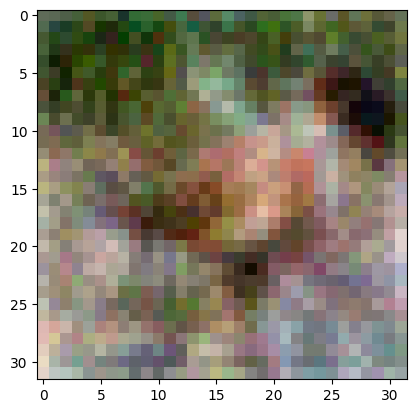

In [35]:
plt.imshow(x_dist[0])
print(y_dist[0])

tf.Tensor(5.0, shape=(), dtype=float64)


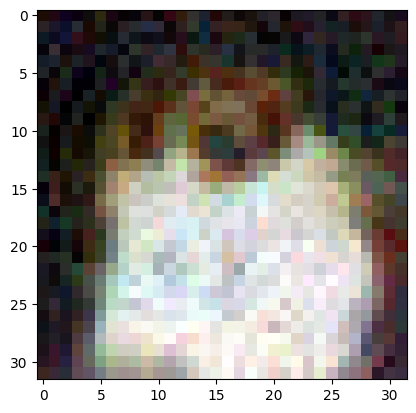

In [36]:
plt.imshow(x_dist[s])
print(y_dist[s])

tf.Tensor(5.0, shape=(), dtype=float64)


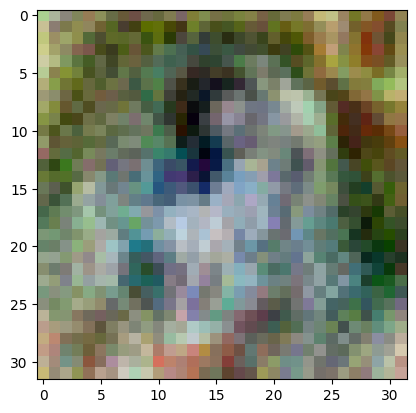

In [37]:
m=5
plt.imshow(x_dist[m])
print(y_dist[m])

tf.Tensor(6.0, shape=(), dtype=float64)


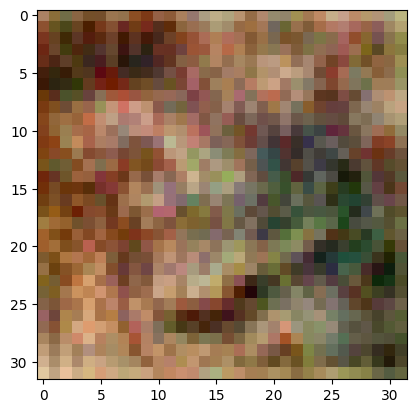

In [38]:
m=4
plt.imshow(x_dist[m])
print(y_dist[m])

In [39]:
x_dist=tf.reshape(x_dist,[s*K,32,32,3])

In [40]:
with open('data_dist_VGGNet_16.pkl', 'wb') as f:
    pickle.dump([x_dist,y_dist],f)

In [41]:
a1=model_V.evaluate(x_dist,y_dist_onehot)

63/63 [==============================] - 0s 7ms/step - loss: 0.0482 - accuracy: 0.9965
